# Memory Information

In [1]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.72GB
Available: 11.90GB
Used: 568.28MB
Percentage: 6.4%


# GPU Information

In [2]:
! nvidia-smi

Wed Apr  7 16:51:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import libraries and data

In [4]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 16.7MB/s 


In [5]:
# Add libraries
import numpy as np
from matplotlib import pyplot as plt
from imutils import paths
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from PIL import Image
from sklearn.svm import SVC
import os
import pickle
import random
from mtcnn import MTCNN
from keras.models import load_model

In [6]:
from google.colab import drive
drive.mount('/content/drive')

train_image_files_path = "/content/drive/MyDrive/Coursework 2/FaceData/Train"
test_image_files_path = "/content/drive/MyDrive/Coursework 2/FaceData/Test"

Mounted at /content/drive


# Data preprocessing


In [ ]:
# extract and plot each detected face in a photograph
detector = MTCNN()
required_size = (160, 160)

# draw each face separately
def draw_faces(filename, result):
	# load the image
  data = pyplot.imread(filename)
	# plot each face as a subplot
	# get coordinates
  x1, y1, width, height = result[0]['box']
  x1, y1 = abs(x1), abs(y1)
  x2, y2 = x1 + width, y1 + height
  # resize pixels to the model size
  face = data[y1:y2, x1:x2]
  image = Image.fromarray(face)
  image = image.resize(required_size)
  face_array = asarray(image)
  return face_array

def read_data(path):
  # Lấy các đường dẫn đến ảnh.
  image_path = list(paths.list_images(path))

  # Đổi vị trí ngẫu nhiên các đường dẫn ảnh
  random.shuffle(image_path)

  # Load image and resize to 160x160
  list_image = []
  for imagePath in image_path:
      pixels = plt.imread(imagePath)
      # create the detector, using default weights
      # detect faces in the image
      face = detector.detect_faces(pixels)
      # display faces on the original image
      face = draw_faces(imagePath, face)
      face = np.expand_dims(face, 0)
      list_image.append(face)

  list_image = np.vstack(list_image)
      
  # get labels name from folder name
  labels = [p.split(os.path.sep)[-2] for p in image_path]
  return list_image, labels

In [ ]:
# X_train, y_train = read_data(train_image_files_path)

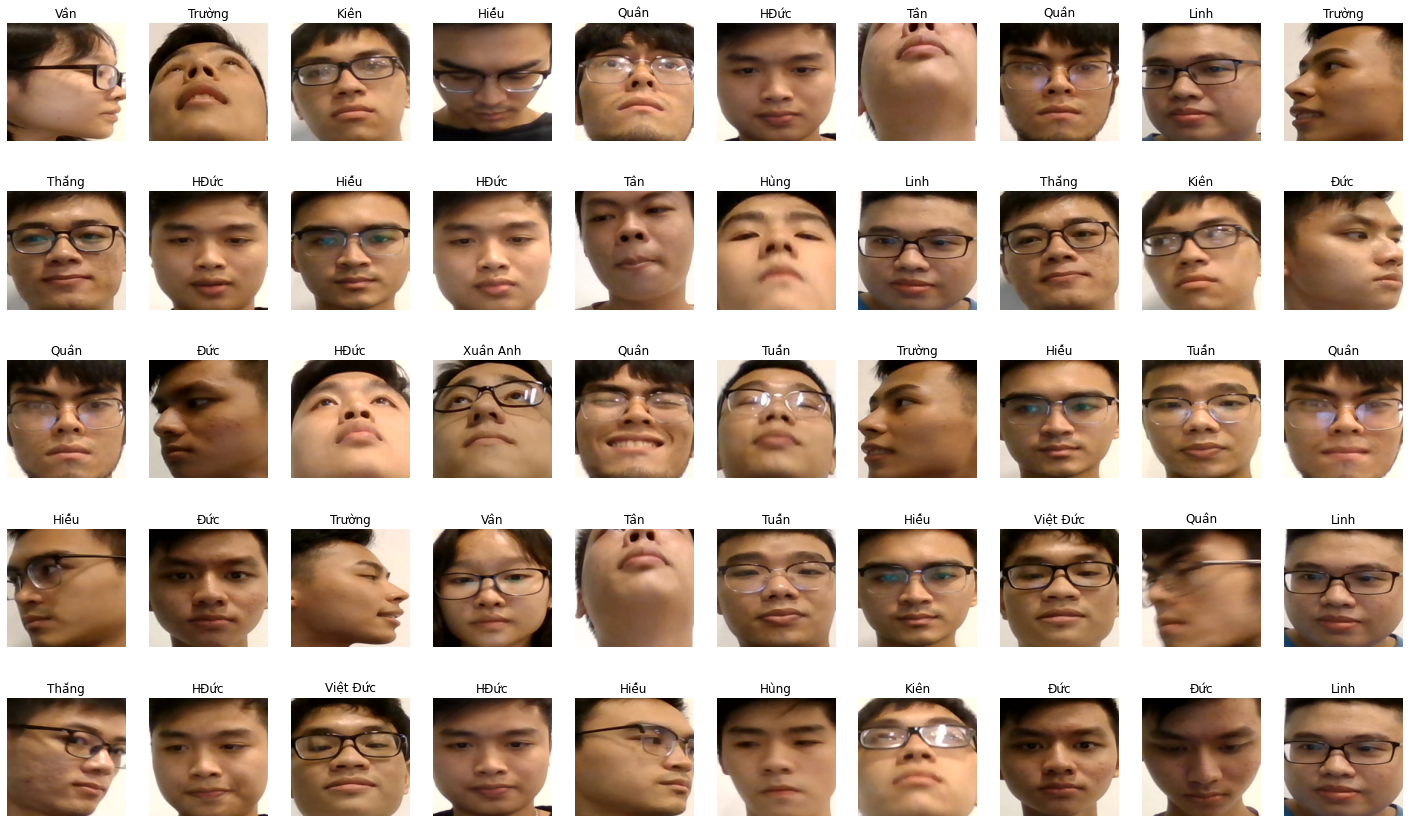

In [ ]:
# plot training faces
plt.figure(figsize=(25, 15))
for i, img in enumerate(X_train[:50]):
  plt.subplot(5, 10, i+1)
  plt.axis("off")
  plt.title(y_train[i])
  plt.imshow(img)

In [ ]:
# X_test, y_test = read_data(test_image_files_path)

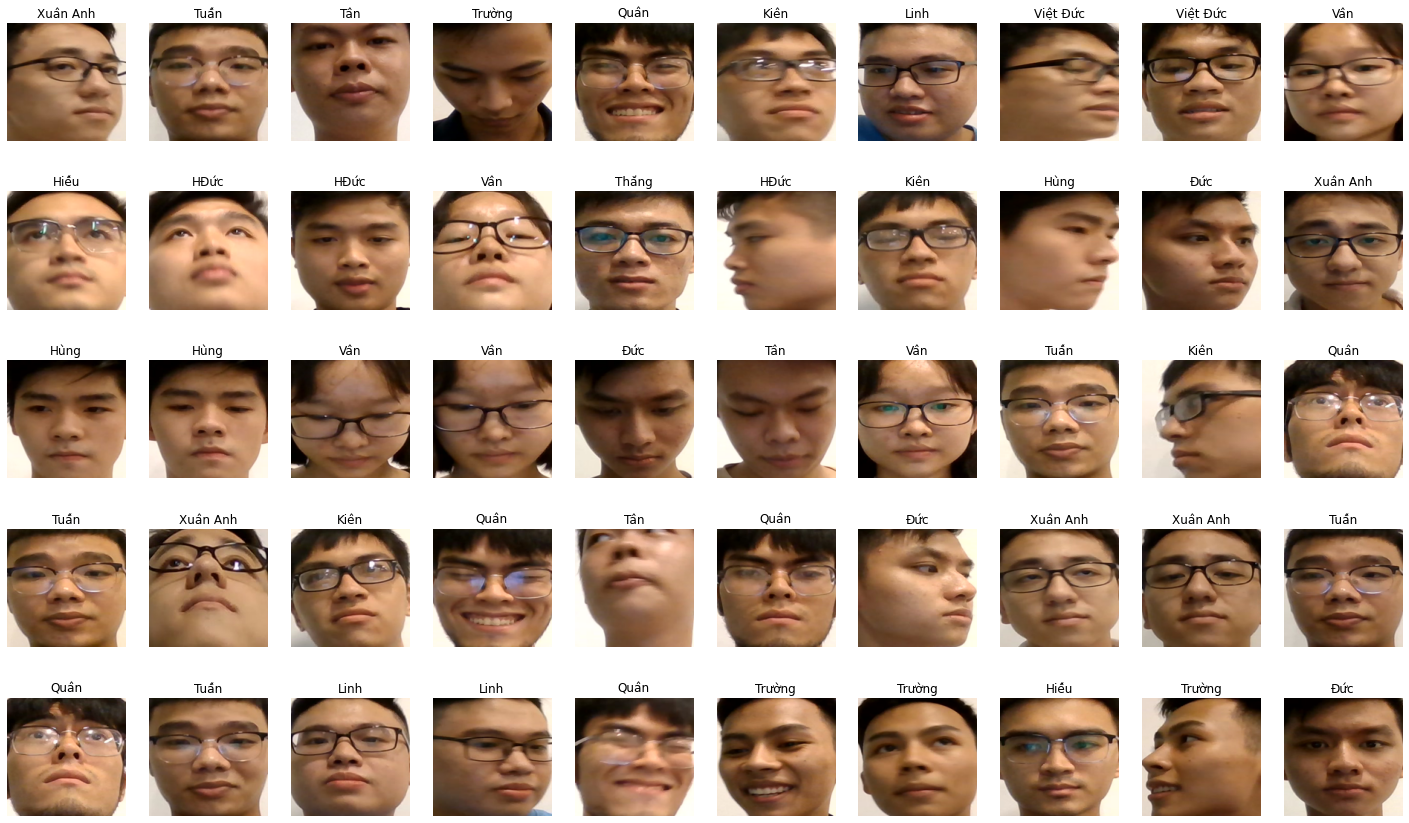

In [ ]:
# plot training faces
plt.figure(figsize=(25, 15))
for i, img in enumerate(X_test[:50]):
  plt.subplot(5, 10, i+1)
  plt.axis("off")
  plt.title(y_test[i])
  plt.imshow(img)

In [26]:
# saving paths
X_train_path = "/content/drive/MyDrive/Coursework 2/train_faces.p"
y_train_path = "/content/drive/MyDrive/Coursework 2/train_labels.p"
X_test_path = "/content/drive/MyDrive/Coursework 2/test_faces.p"
y_test_path = "/content/drive/MyDrive/Coursework 2/test_labels.p"

In [ ]:
# save training faces into a pickle file
pickle.dump(X_train, open(X_train_path, "wb"))
pickle.dump(y_train, open(y_train_path, "wb"))

In [ ]:
# save testing faces into a pickle file

pickle.dump(X_test, open(X_test_path, "wb"))
pickle.dump(y_test, open(y_test_path, "wb"))

# Load dataset

In [ ]:
# saving paths
X_train_path = "/content/drive/MyDrive/Coursework 2/train_faces.p"
y_train_path = "/content/drive/MyDrive/Coursework 2/train_labels.p"
X_test_path = "/content/drive/MyDrive/Coursework 2/test_faces.p"
y_test_path = "/content/drive/MyDrive/Coursework 2/test_labels.p"

In [27]:
# load training dataset
X_train = pickle.load(open(X_train_path, "rb"))
y_train = pickle.load(open(y_train_path, "rb"))

# load testing dataset
X_test = pickle.load(open(X_test_path, "rb"))
y_test = pickle.load(open(y_test_path, "rb"))

# Feature Extractor

In [ ]:
# load the model
feature_extractor = load_model('/content/drive/MyDrive/Coursework 2/facenet_keras.h5')
# summarize input and output shape
print(feature_extractor.inputs)
print(feature_extractor.outputs)

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


In [ ]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = np.expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

In [ ]:
# convert each face in the train set to an embedding
X_train_new = []
for face_pixels in X_train:
	embedding = get_embedding(feature_extractor, face_pixels)
	X_train_new.append(embedding)
X_train_new = np.asarray(X_train_new)
print(X_train_new.shape)

# convert each face in the test set to an embedding
X_test_new = []
for face_pixels in X_test:
	embedding = get_embedding(feature_extractor, face_pixels)
	X_test_new.append(embedding)
X_test_new = np.asarray(X_test_new)
print(X_test_new.shape)

(381, 128)
(137, 128)


In [ ]:
# normalize input vectors
in_encoder = Normalizer(norm='l2')
X_train_normalized = in_encoder.fit_transform(X_train_new)
X_test_normalized = in_encoder.transform(X_test_new)

In [30]:
# label encode targets
out_encoder = LabelEncoder()
y_train_encoded = out_encoder.fit_transform(y_train)
y_test_encoded = out_encoder.transform(y_test)

In [32]:
# get the inverse encoder labels
label_names = []

for i in range(14):
  name = out_encoder.inverse_transform([i])[0]
  label_names.append(name)

print(label_names)

['Hiếu', 'Hùng', 'HĐức', 'Kiên', 'Linh', 'Quân', 'Tân', 'Thắng', 'Trường', 'Tuấn', 'Vân', 'Việt Đức', 'Xuân Anh', 'Đức']


# Define and train classifier

In [ ]:
# fit model
classifier = SVC(kernel='linear', probability=True, C=80)
classifier.fit(X_train_normalized, y_train_encoded)

SVC(C=80, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

# Test model

In [ ]:
# predict
y_train_predict = classifier.predict_proba(X_train_normalized)
y_test_predict = classifier.predict_proba(X_test_normalized)

# score
score_train = accuracy_score(y_train_encoded, np.argmax(y_train_predict, axis=1))
score_test = accuracy_score(y_test_encoded, np.argmax(y_test_predict, axis=1))
# summarize
print('Accuracy: train = %.3f, test = %.3f' % (score_train*100, score_test*100))

Accuracy: train = 100.000, test = 100.000


In [ ]:
# save model
save_path = "/content/drive/MyDrive/Coursework 2/Face Classification.h5"
pickle.dump(classifier, open(save_path, 'wb'))

# Visualize

In [ ]:
miss_class = []
print(miss_class)

if len(miss_class):
  for i, y in enumerate(y_train_predict):
    if (y != y_train_encoded[i]):
      miss_class.append(i)

  for miss in miss_class:
    plt.imshow(X_train[miss])
    plt.axis("off")
    plt.show()

[]


In [ ]:
# plot training faces
plt.figure(figsize=(25, 228))
for i, img in enumerate(X_test):
  plt.subplot(76, 10, i+1)
  plt.axis("off")
  predict = out_encoder.inverse_transform([np.argmax(y_test_predict[i])])
  percent = np.max(y_test_predict[i])
  plt.title("{}: {:.2f}%".format(predict[0], percent*100))
  plt.imshow(img)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# plot training faces
plt.figure(figsize=(25, 84))
for i, img in enumerate(X_test):
  plt.subplot(28, 10, i+1)
  plt.axis("off")
  predict = out_encoder.inverse_transform([np.argmax(y_test_predict[i])])
  percent = np.max(y_test_predict[i])
  plt.title("{}: {:.2f}%".format(predict[0], percent*100))
  plt.imshow(img)

Output hidden; open in https://colab.research.google.com to view.

# Test new data

In [13]:
# extract and plot each detected face in a photograph
detector = MTCNN()
required_size = (160, 160)
reference_filename = "/content/drive/MyDrive/Coursework 2/FaceData/Validation"
label_names = ['Hiếu', 'Hùng', 'HĐức', 'Kiên', 'Linh', 'Quân', 'Tân', 'Thắng', 'Trường', 'Tuấn', 'Vân', 'Việt Đức', 'Xuân Anh', 'Đức']
feature_extractor_path = "/content/drive/MyDrive/Coursework 2/facenet_keras.h5"
classifier_path = "/content/drive/MyDrive/Coursework 2/Face Classification.h5"

def read_data(path):
  # Get all the image paths
  image_path = list(paths.list_images(path))

  # Shuffle images
  random.shuffle(image_path)

  # Load image and resize to 160x160
  list_image = []
  for imagePath in image_path:
      pixels = plt.imread(imagePath)
      # detect faces in the image
      face = detector.detect_faces(pixels)
      # display faces on the original image
      x1, y1, width, height = face[0]['box']
      x1, y1 = abs(x1), abs(y1)
      x2, y2 = x1 + width, y1 + height
      # resize pixels to the model size
      face = pixels[y1:y2, x1:x2]
      image = Image.fromarray(face)
      image = image.resize(required_size)
      face_array = np.asarray(image)
      face_array = np.expand_dims(face_array, 0)
      list_image.append(face_array)

  list_image = np.vstack(list_image)
      
  # get labels name from folder name
  labels = [p.split(os.path.sep)[-1][:-4] for p in image_path]
  return list_image, labels

# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = np.expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]


# make predictions
def make_reference(reference_path):
  X, y = read_data(reference_filename)

  # load the feature extractor
  feature_extractor = load_model(feature_extractor_path)

  X_new = []

  for face_pixels in X:
    embedding = get_embedding(feature_extractor, face_pixels)
    X_new.append(embedding)
  X_new = np.asarray(X_new)

  # normalize input vectors
  X_normalized = Normalizer(norm='l2').fit_transform(X_new)

  # load model
  classifier = pickle.load(open(classifier_path, "rb"))

  # make predictions
  y_predict = classifier.predict(X_normalized)

  return y_predict

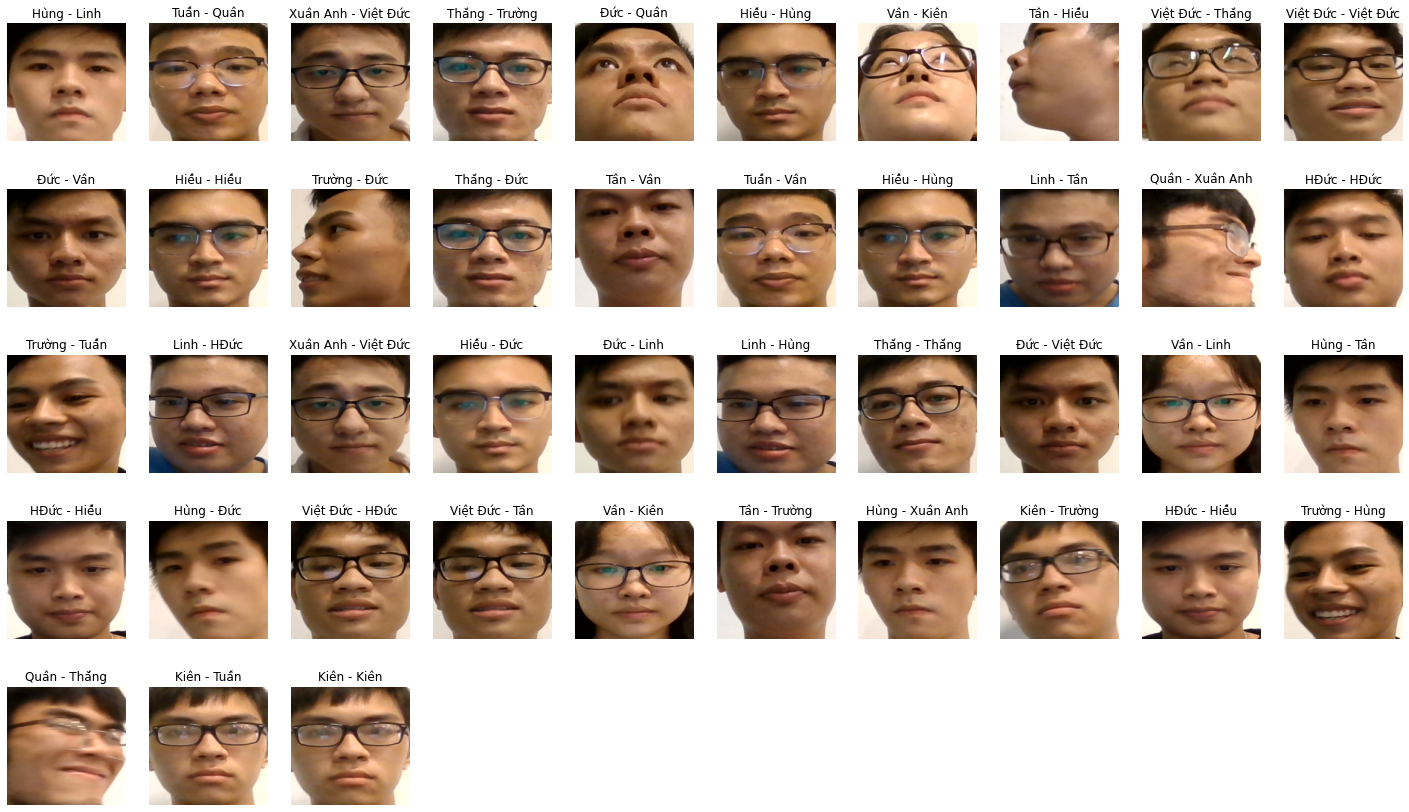

In [14]:
predicts = make_reference(reference_filename)
# plot training faces
plt.figure(figsize=(25, 30))
for i, img in enumerate(X):
  plt.subplot(10, 10, i+1)
  plt.axis("off")
  actual = y[i][:-2]
  predict = label_names[predicts[i]] # exclude the number at the end
  # percent = np.max(y_predict[i])
  plt.title("{} - {}".format(actual, predict))
  plt.imshow(img)